# Transactions processing 

This section has two objectives: 
- 1) To map the right station-access combination to the unique station ID form the the station database. 
- 2) Data manipulation to get the the time series for each station - the rows will have the timestamp for each transaction, and the columns will have the station ID. 

In [1]:
import pandas as pd 
import numpy as np
import xlrd
import csv

import os
from os import listdir
import functools
import glob
import datetime
import matplotlib.pyplot as plt

## Reading files - raw data

In [2]:
## Read all files 
PATH = '../data/transactions'
all_files = []
for root,dirs,files in os.walk(PATH):
    for file in files:
        all_files.append(os.path.join(root, file))
        
## Files June 2015 to June 2017
files_2015 = list(filter(lambda f: f.endswith('.csv'), all_files))

#Files July 2017 to April 2021
years = '2017|2018|2019|2020|2021'
months = 'Enero-2017|Febrero-2017|Marzo-2017|Abril-2017|Mayo-2017|Junio-2017|~'
files_2017 = pd.Series(list(filter(lambda f: f.endswith('.xlsx'), all_files)))
files_2017 = files_2017[files_2017.str.contains(years)]
files_2017 = files_2017[~files_2017.str.contains(months)]

files = files_2015 + list(files_2017)
files = [files[0]] + files[3:] #Dropping Jun and July 

In [3]:
%%time 
raw_month = []
sheet = 'Validaciones Consolidado'
sheet = 'Validaciones Tullave'
for file in files:
    if file.endswith('.csv'):
        raw_month.append(pd.read_csv(file, header = 6))
    elif file.endswith('.xlsx'):
        condition = '2017|2018|Enero 2019|Febrero 2019'
        consolidado = pd.Series(file).str.contains(condition)[0]
        if consolidado:
            sheet = 'Validaciones Consolidado'
        else:
            sheet = 'Validaciones Tullave'

        raw_month.append(pd.read_excel(file, header = 6,sheet_name=sheet))

CPU times: user 20min 45s, sys: 6.99 s, total: 20min 52s
Wall time: 20min 58s


### Functions 

In [4]:
def clean_col_names(df):
    ''' 
    Clean dates - After July 2018, dates are not read as a string, but as an actual date. 
    This is not consistent with the other code, so I transform it to a string (and remove 
    the time portion becuase it is not useful)
    '''
    col_names = []
    for col in df.columns:
        condition = isinstance(col, datetime.date)
        if condition:
            name = str(col).split(' ')[0]
        else:
            name = col
        col_names.append(name)
    df.columns = col_names
    return df 

In [5]:
def clean_stations(df, station_database):
    ''' 
    Cleans station data. For each station, it create a time series of transactions every 15 minutes.  
    Parameters: 
    ------------
    - df: raw transactions data 
    - station_database: DataFrame. Station database with all posible combinations of station_access. 
    
    ------------
    Returns: 
    Pandas DataFrame. Transactions every 15 mins. Index is timestamp, columns are stations
    '''
    ### asserts 
    # classification stations are in df 
    # values in classifications are only DUAL or BRT
    
    #############################################
    # Match Station-access unique combinations #
    ############################################
    
    # For before July 2018. 
    if 'indent' in df.columns:
    
        time_indent = 3
        indent_level = {'zone':0, 'station':1, 'access':2}

        new_cols = ['zone', 'station','access']
        for key, value in indent_level.items(): 
            df[key] = df['indent']
            df[key] = df[key].where(df[key]!=value,df['Etiquetas de fila']).astype(str)
            df[key] = df[key].replace(to_replace = '^\\d', value =  np.nan, regex = True)\
                                .fillna(method = 'ffill')
        #Keep only time indent 
        df = df[df.indent == time_indent].drop(columns = ['indent','Total general'])
        df.rename(columns = {'Etiquetas de fila':'time'}, inplace = True)
     
    # For July 2018 to Present 
    else:
        
        renanme_cols = {'Línea':'zone','Estación':'station', 'Acceso de Estación':'access', 
                        'Intervalo':'time'}
        df = df.rename(columns = renanme_cols)
        df = clean_col_names(df)
        
        if 'Fase 3' in df.columns: 
            df.drop(columns = 'Fase 3', inplace = True )
        
    df['station_access'] = df['station'] + '-' + df['access']
    station_database['station_access'] = station_database['nombreestacion'] + '-' + station_database['nombreaccesoestacion']
    df = df.merge(station_database, how = 'inner', on = 'station_access')
    
    ################
    # Clean format #
    ################
    
    #Dates information
    dates = df.columns[df.columns.str.contains(pat="\d", regex = True)]
    index = ['zone', 'station_name', 'time']
    df = pd.melt(df, id_vars=index, value_vars = dates, var_name='date', value_name='transactions')
    df['transactions'] = df['transactions'].replace(',','', regex=True).fillna(0).astype(int)
    df = df[~df.date.str.contains('Unnamed')] #Drop unnamed dates (error in excel to csv export) 
    df.dropna(subset = ['zone'], inplace = True)
    
    #Date and time format 
    df.time = df.time.astype(str)
    df.date = df.date.astype(str)
    
    #There are 3 different time formats. 
    df['timestamp'] = pd.to_datetime(df['date'] + df['time'], format = '%d/%m/%Y%H:%M', errors = 'coerce')
    
    if df.timestamp.isna().all():
        df['timestamp'] = pd.to_datetime(df['date'] + df['time'], format = '%Y-%m-%d%H:%M:%S', errors = 'coerce')
    
    if df.timestamp.isna().all():
        df['timestamp'] = pd.to_datetime(df['date'] + df['time'], format = '%Y-%m-%d%H:%M', errors = 'coerce')
    
    #Transform to a nice table 
    df = df.groupby(['station_name','timestamp']).agg({'transactions':'sum'}).reset_index()
    df = df.pivot(index = ['timestamp'], columns = 'station_name', values = 'transactions').reset_index()
    
    return df#.fillna(0).set_index('timestamp')


    

### Processing 

In [6]:
#Import stations database 
stations_path = '../data/clean_stations_database_v2.csv'
stations_database = pd.read_csv(stations_path)
station_database = stations_database

In [7]:
%%time 
cleaned_list = []
counter = 0 
for month in raw_month:
    a = clean_stations(month, stations_database)
    month_name = files[counter].split('/')[-1]
    print('Month:{}'.format(month_name))
    print('Number of observations:{}. Number of unique stations:{}'.format(a.shape[0], a.shape[1]))
    print('')
    cleaned_list.append(a)
    counter += 1
    
final = pd.concat(cleaned_list, axis = 0)
final = final.sort_values('timestamp')
final = final.set_index('timestamp')

Month:11 TM Reporte de Validaciones Troncales 30 Nov-2015.csv
Number of observations:2610. Number of unique stations:147

Month:08 TM Reporte de Validaciones Troncales 31 Ago-2015.csv
Number of observations:2728. Number of unique stations:144

Month:12 TM Resumen de Validaciones 01 al 31 Dic-2015 cada 15 minuto.csv
Number of observations:2697. Number of unique stations:147

Month:10 TM Resumen de Validaciones 01 al 31 Oct-2015 cada 15 minuto.csv
Number of observations:2728. Number of unique stations:145

Month:09 TM Repoorte de Validaciones Troncales 30 Sep-2015.csv
Number of observations:2610. Number of unique stations:144

Month:TM Resumen de Validaciones 01 al 31 Enero-2017 cada 15 minutos.csv
Number of observations:2697. Number of unique stations:147

Month:TM Resumen de Validaciones 01 al 31 Mayo-2017 cada 15 minutos.csv
Number of observations:2728. Number of unique stations:148

Month:TM Resumen de Validaciones 01 al 30 Junio-2017 cada 15 minutos.csv
Number of observations:2640. 

Month:09 TM Resumen de Validaciones Troncales al 30 Septiembre 2018 Intervalo 15 Mint.xlsx
Number of observations:2697. Number of unique stations:148

Month:07 TM Resumen de Validaciones Troncales al 31 Julio 2018 Intervalo 15 Mint.xlsx
Number of observations:2697. Number of unique stations:148

Month:03 TM Resumen de Validaciones Troncales al 31 Marzo 2018 Intervalo 15 Mint.xlsx
Number of observations:2728. Number of unique stations:148

Month:10 TM Resumen de Validaciones Troncales al 31 Octubre 2018 Intervalo 15 Mint.xlsx
Number of observations:2728. Number of unique stations:148

Month:08 TM Resumen de Validaciones Troncales al 31 Agosto 2018 Intervalo 15 Mint.xlsx
Number of observations:2728. Number of unique stations:148

Month:05 TM Resumen de Validaciones Troncales al 31 Mayo 2018 Intervalo 15 Mint.xlsx
Number of observations:2728. Number of unique stations:148

Month:02 TM Resumen de Validaciones Troncales al 28 Febrero 2018 Intervalo 15 Mint.xlsx
Number of observations:2728. 

## Saving transactions preprocessing 

In [8]:
final.fillna(0).to_csv('../data/transactions_clean.csv', )

## Debugging stations

In [9]:
#Station name to debug 
problem_name = '(02103) Mazurén'

#15 mins transactions transactions 
debug = final 

value = 150
transactions_15 = debug

# Daily transactions 
debug = debug.reset_index()
debug['date'] = debug.timestamp.dt.date
debug = debug.drop(columns = 'timestamp')
transactions_day = debug.groupby('date').sum()

value = 150

In [13]:
#15 mins transactions transactions 
value = 0
transactions_15[[problem_name]].iloc[value: value + 50].head()

station_name         (02103) Mazurén
timestamp                           
2015-08-01 00:00:00              NaN
2015-08-01 00:15:00              NaN
2015-08-01 00:30:00              NaN
2015-08-01 00:45:00              NaN
2015-08-01 03:00:00              NaN

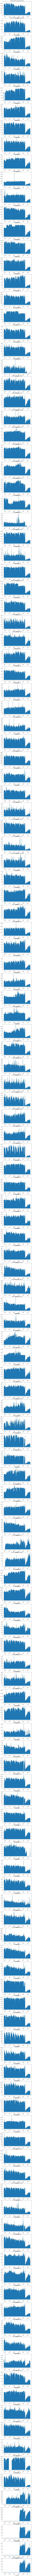

In [916]:
# 15 mins transactions plot 
fig, axs = plt.subplots(len(transactions_15.columns), 1, figsize = (8,800))
counter = 0
for col in transactions_15.columns:
    if col == 'date':
        pass
    else:
        transactions_15[col].fillna(0).astype(float).plot(ax = axs[counter])
        axs[counter].set_title(col)
    counter += 1

In [11]:
# Daily transactions 
value = 50
transactions_day[[problem_name]].iloc[value: value + 50].head()

station_name  (02103) Mazurén
date                         
2015-09-20             5117.0
2015-09-21            18755.0
2015-09-22            20244.0
2015-09-23            19183.0
2015-09-24            19610.0

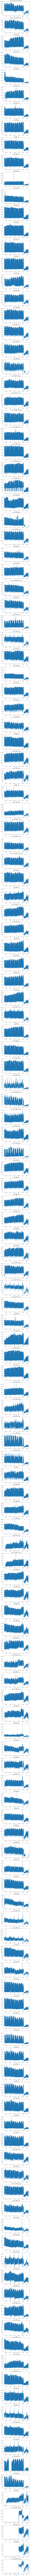

In [918]:
# Daily transactions plots 

fig, axs = plt.subplots(len(transactions_day.columns), 1, figsize = (8,800))
counter = 0
for col in transactions_day.columns:
    if col == 'date':
        pass
    else:
        transactions_day[col].fillna(0).astype(float).plot(ax = axs[counter])
        axs[counter].set_title(col)
    counter += 1
    